# CS 584 Assignment 1 -- Machine Learning and NLP Basis

#### Name: Agamdeep S. Chopra

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement the preprocessing.
3. Implement tokenization.
4. Implement feature extraction.
5. Implement Logistic Regression.
6. Implement Stochastic Gradient Descent and Mini-batch Gradient Descent.
7. Evaluate all the experiments and compare all the results.

*** Please read the code very carefully and install these packages (NumPy, Pandas, sklearn, tqdm, and matplotlib) before you start ***

## 1. Data Processing (30 points)

* Download the dataset from Canvas
* Load data by using Pandas
* Preprocessing
* Tokenization
* Split data
* Feature extraction (TF-IDF)

### 1.1 Load Data

Run the following cells (Please make sure the paths of data files are correct.)

In [1]:
import pandas as pd

train_df = pd.read_csv('./data/train.csv', header=None)
train_df.columns = ['label', 'title', 'text']
train_df.head()

,label,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [2]:
test_df = pd.read_csv('./data/test.csv', header=None)
test_df.columns = ['label', 'title', 'text']
test_df.head()

,label,title,text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


### 1.2 Preprocess (Fill the code: 10 points)
In this section, you need to remove all the unrelated characters, including punctuation, urls, and numbers. Please fill up the functions and test them by running the following cell.

In [3]:
import re
import string

class Preprocesser(object):
    def __init__(self, punctuation=True, url=True, number=True):
        self.punctuation = punctuation
        self.url = url
        self.number = number
    
    def apply(self, text):
        if self.url:
            text = self._remove_url(text)
            
        if self.punctuation:
            text = self._remove_punctuation(text)
            
        if self.number:
            text = self._remove_number(text)
        
        text = re.sub(r'\s+', ' ', text)
            
        return text
    
        
    def _remove_punctuation(self, text):
        ''' Please fill this function to remove all the punctuations in the text
        '''
        return text.translate(str.maketrans('','', string.punctuation))
    
    def _remove_url(self, text):
        ''' Please fill this function to remove all the urls in the text
        '''
        return re.sub(r'http\S+','',text)
    
    def _remove_number(self, text):
        ''' Please fill this function to remove all the numbers in the text
        '''
        return text.translate(str.maketrans('','', string.digits))

##### Test your implementation by running the following cell.

In [4]:
text = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processer = Preprocesser()
clean_text = processer.apply(text)

print(f'"{text}"') 
print('===>')
print(f'"{clean_text}"')

"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"Interest rates are trimmed to by the South African central bank but the lack of warning hits the rand and surprises markets"


### 1.3 Tokenization (Fill the code: 5 points)

In [5]:
def tokenize(text, lemma=False):
    ''' Please fill this function to tokenize text.
    '''
    return text.split()

##### Test your implementation by running the following cell.

In [6]:
text = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processer = Preprocesser()
clean_text = processer.apply(text)
tokens = tokenize(clean_text)

print(f'{text} ==> {tokens}')

Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets. ==> ['Interest', 'rates', 'are', 'trimmed', 'to', 'by', 'the', 'South', 'African', 'central', 'bank', 'but', 'the', 'lack', 'of', 'warning', 'hits', 'the', 'rand', 'and', 'surprises', 'markets']


### 1.4 Data split (Fill the code: 5 points)

In [7]:
from sklearn.model_selection import train_test_split

text_train = train_df['text'].values.astype(str)
label_train = train_df['label'].values.astype(int) - 1 # -1 because labels start from 1

text_test = test_df['text'].values.astype(str)
label_test = test_df['label'].values.astype(int) - 1 # -1 because labels start from 1


### Start your code, split the text_train and label_train into training and validation
### Make sure the names of varables are "text_train", "label_train", "text_valid", and "label_valid"

text_train, text_valid, label_train, label_valid = train_test_split(text_train,label_train,test_size = 0.06333)

### End

print('The size of training set:', text_train.shape[0])
print('The size of validation set:', text_valid.shape[0])
print('The size of test set:', text_test.shape[0])

The size of training set: 112400
The size of validation set: 7600
The size of test set: 7600


### 1.5 Feature Extraction (Fill the code: 10 points)

In [8]:
from collections import defaultdict
import numpy as np
from tqdm.notebook import tqdm

class TfIdfExtractor(object):
    
    def __init__(self, vocab_size=None):
        self.vocab_size = vocab_size
        
        self.vocab = defaultdict(lambda: 0)
        self.word2idx = {}
        self.df = defaultdict(lambda: 0)
        self.num_doc = 0
        
        self.processer = Preprocesser()
        
        
    def fit(self, texts):
        ''' In this function, you are required to implement the fitting process.
                1. Construct the vocabulary (self.vocab).
                2. Construct the document frequency dictionary (self.df).
                3. Sort the vocabulary based on the frequence (self.vocab).
            Input:
                texts: a list of text (training set)
            Output:
                None
        '''

        self.num_doc = len(texts)
        
        for text in tqdm(texts, desc='fitting text'):
            clean_text = self.processer.apply(text)
            tokens = tokenize(clean_text)
            
            ### Start your code (step 1 & 2)
            for i in tokens:
                self.vocab[i]
                self.df[i] += 1
            ### End
        
        ### Start your code (Step 3)
        self.vocab = dict(sorted(self.vocab.items(), key=lambda x: self.df[x[0]], reverse=True))
        #print(self.vocab)
        ### End
        
        if self.vocab_size is not None:
            self.vocab = {key: self.vocab[key] for key in list(self.vocab.keys())[:self.vocab_size]}
        
        self.word2idx = {key: idx for idx, key in enumerate(self.vocab.keys())}
        
        #print(self.vocab)
        #print(self.word2idx)
        
    def transform(self, texts):
        ''' In this function, you need to encode the input text into TF-IDF vector.
            Input:
                texts: a list of text.
            Ouput:
                a N-d matrix (Tf-Idf) 
        '''
        tfidf = np.zeros((len(texts), len(self.vocab)))
        
        for i, text in tqdm(enumerate(texts), desc='transforming', total=len(texts)):
            clean_text = self.processer.apply(text)
            tokens = tokenize(clean_text)      
            tfidf[i,:] = [tokens.count(list(self.vocab.keys())[j]) for j in range(len(self.vocab))]

        tfidf = np.log(1+tfidf)*np.log(1+(len(texts))/np.array([self.df[list(self.vocab.keys())[i]] for i in range(len(self.vocab))]))

        return tfidf

##### Test your implementation by running the following cell.

In [9]:
extractor = TfIdfExtractor(vocab_size=400)
extractor.fit(text_train[:100])
X = extractor.transform(text_train[:10])

X[0:10]

fitting text:   0%|          | 0/100 [00:00<?, ?it/s]

transforming:   0%|          | 0/10 [00:00<?, ?it/s]

array([[0.05136773, 0.13414352, 0.08675648, ..., 0.        , 0.        ,
        0.        ],
       [0.10273546, 0.08463514, 0.08675648, ..., 0.        , 0.        ,
        0.        ],
       [0.08141593, 0.13414352, 0.08675648, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08141593, 0.08463514, 0.17351296, ..., 0.        , 0.        ,
        0.        ],
       [0.05136773, 0.        , 0.13750577, ..., 0.        , 0.        ,
        0.        ],
       [0.08141593, 0.08463514, 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### 1.5.4 Run the following code to obtain the TD-IDF and One-hot labels

In [10]:
# You can change this number to see the difference of the performances. (larger vocab size needs more memory)
vocab_size = 1000
num_class = 4

extractor = TfIdfExtractor(vocab_size=vocab_size)
extractor.fit(text_train)

x_train = extractor.transform(text_train)
x_valid = extractor.transform(text_valid)
x_test = extractor.transform(text_test)


# convert label to one-hot vector
y_train = np.zeros((label_train.shape[0], num_class))
y_train[np.arange(label_train.shape[0]), label_train] = 1

y_valid = np.zeros((label_valid.shape[0], num_class))
y_valid[np.arange(label_valid.shape[0]), label_valid] = 1

y_test = np.zeros((label_test.shape[0], num_class))
y_test[np.arange(label_test.shape[0]), label_test] = 1


print('The size of training set:', x_train.shape)
print('The size of validation set:', x_valid.shape)
print('The size of test set:', x_test.shape)

fitting text:   0%|          | 0/112400 [00:00<?, ?it/s]

transforming:   0%|          | 0/112400 [00:00<?, ?it/s]

transforming:   0%|          | 0/7600 [00:00<?, ?it/s]

transforming:   0%|          | 0/7600 [00:00<?, ?it/s]

The size of training set: (112400, 1000)
The size of validation set: (7600, 1000)
The size of test set: (7600, 1000)


## 2. Logistic Regression (60 points)
In this section, you are required to implement a Logistic Regression(LR) model with $L_2$ regularization from scratch. 


The objective function of LR:

<center> $J = -\frac{1}{N}\sum_{i=1}^{N}\sum_{k=1}^{K}y_{ik}log\frac{e^{f_k}}{\sum_{c=1}^{K}e^{f_c}} + \lambda \sum_{j=1}^{d}w_{kj}^2$ </center>

**Deliverable 1**: Given the objective function, please show the steps to derive the graident of J with respecty of $w_k$. You can either list the steps in the notebook or submit a pdf with all the steps in the submission. **(10 points)**

Answer: Attached PDF document.

### 2.1 LR and softmax function (Fill the code, 20 points)

In [25]:
#Note: I noticed some bugs in the provided code/instructions that I think I was able to fix. I also simplified the code rewriting the w,b,dw, and db as instance attributes.

def softmax(x):
    ''' Compute the softmax function for each row of the input x.
        
        Inputs:
            x: A D dimensional vector or N x D dimensional numpy matrix.
        Outputs:
            x: You are allowed to modify x in-place
    '''
    ### Start your code
    # Using the x - max(x) to prevent overflow
    try:
        x = np.exp(x - np.max(x))
        x = (x.T/np.sum(x, axis=1)).T
    except:
        x = np.exp(x - np.max(x))
        x = x/np.sum(x)
    ### End
    return x


class LogisticRegression(object):
    
    def __init__(self, vocab_size, num_class, lam):
        self.vocab_size = vocab_size
        self.num_class = num_class
        self.lam = lam
        
        ### Start your code (initialize weight(w) and bias(b))
        ### hint: you could use np.random.rand() to randomly initialize the parameters

        self.w = np.random.rand(self.vocab_size, num_class)
        self.w_grad = np.zeros(self.w.size)
        self.b = np.zeros((1, num_class))
        self.b_grad = np.zeros(self.b.size)
        
        ### End
        
    def objective(self, x, y):
        ''' Implement the objective function
            Inputs:
                x: N-d matrix
                y: N-1 vector
            Output:
                the objective value of LR (scalar)
        '''
        loss = 0
        
        ### Start your code
        #The loss function simplified to matrix form - the L2 term. Adding the L2 term made the loss values act strenge. I am not sure why.
        loss = ((1/x.shape[0])*(np.log(np.sum(np.exp(-x@self.w-self.b),axis=1)) + np.trace((x@self.w+self.b)@y.T)))[0]
        ### End
        
        return loss
        
    
    def gradient(self, x, y):
        ''' Implement the gradient of J with respect to w (in Deliverable 1)
            Inputs:
                x: N-d matrix
                y: N-1 vector
            Output:
                the gradient of J w.r.t weight (d-K matrix)
                the gradient of J w.r.t bias (K vector)
        '''
        ### Start your code
        # The gradient update algorithm in matrix form as derived in the supplimental derivation.pdf file.
        self.w_grad = (1/x.shape[0])*(x.T@(y-softmax(-x@self.w-self.b))) + 2*self.lam*self.w
        self.b_grad = (1/x.shape[0])*(np.sum((y-softmax(-x@self.w-self.b)),axis=0))
        ### End
        
    
    
    def gradient_descent(self,x,y, lr):
        ''' Implement the graident descent. 
            Updating weights and bias based on Equation: w = w - learning_rate * gradient)
            
            Inputs:
                w_grad: a matrix which is the gradient of J w.r.t to weight
                b_grad: a vector wich is the graident of J w.r.t to bias
            Output:
                None
        '''
        ### Start your code
        self.gradient(x,y) # <- calculating the gradients
        # updating the paramaters with the new gradient values
        self.w = self.w - lr*self.w_grad
        self.b = self.b - lr*self.b_grad
        ### End
        

    
    def predict(self, x):
        y_hat = softmax(np.dot(x, self.w)+self.b).squeeze()
        #y_hat = softmax(np.dot(x, self.w)).squeeze() <- for some reason the provided code never used the bias term so I rewrote the prediction equation to include bias.
        return np.argmax(y_hat, axis=-1)

### 2.2 Stochastic Gradient Descent (SGD) (Fill the code, 15 points)

In [97]:
#Note: I restructured and rewrote parts of this code to better fit my implementation.

def sgd(model, X, y, Xv, yv, lr, lam, num_epoch=100):
    ''' Implement SGD
        Inputs:
            X: N-d matrix
            y: N vector
            lr: learning rate
            lam: lambda
            num_epoch: the number of epochs
        Output:
            1. A list of training losses against epoch
            2. A list of validation losses against epoch
    '''
    train_losses = []
    valid_losses = []
    
    n = X.shape[0]
    
    for e in range(num_epoch):
        train_loss = 0.
        
        ### Start your code here (Please implement SGD and obtain the training loss)
        for i in range(n):
            if train_loss == 0.:
                train_loss = model.objective(X[i].reshape((1,X.shape[1])),y[i].reshape((1,y.shape[1])))
            else:
                train_loss = (train_loss + model.objective(X[i].reshape((1,X.shape[1])),y[i].reshape((1,y.shape[1]))))/2
            model.gradient_descent(X[i].reshape((1,X.shape[1])),y[i].reshape((1,y.shape[1])),lr)
        ### End
        
        valid_loss = 0.
        
        ### Start your code (Using validation set to obtain the validation loss)
        valid_loss = model.objective(Xv,yv)
        ### End
        
        
        print(f'At epoch {e+1}, training loss: {train_loss:.9f}, validation loss: {valid_loss:.9f}.')
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
            
    return train_losses, valid_losses

Run SGD

In [103]:
''' Update the hyper-parameters (num_epoch, lr, and lam) according to your observation to achieve better performance.
'''
num_epoch = 10
lr = 0.65E-2
lam = 1E-4

sgd_lr = LogisticRegression(vocab_size, num_class, lam)
sgd_train_losses, sgd_valid_losses = sgd(sgd_lr, x_train, y_train, x_valid, y_valid, lr, lam, num_epoch)

At epoch 1, training loss: 0.068298847, validation loss: 4.493543308.
At epoch 2, training loss: 0.070566364, validation loss: 3.640689023.
At epoch 3, training loss: 0.069894862, validation loss: 2.911714886.
At epoch 4, training loss: 0.069256109, validation loss: 2.287291679.
At epoch 5, training loss: 0.068896805, validation loss: 1.750459541.
At epoch 6, training loss: 0.068709072, validation loss: 1.287967819.
At epoch 7, training loss: 0.068609820, validation loss: 0.889065430.
At epoch 8, training loss: 0.068555645, validation loss: 0.544784366.
At epoch 9, training loss: 0.068525189, validation loss: 0.247529093.
At epoch 10, training loss: 0.068507732, validation loss: -0.009186418.


### 2.3 Mini-batch Gradient Descent (Fill the code: 15 points)

In [15]:
#Note: I restructured and rewrote parts of this code to better fit my implementation.

def mini_batch_gd(model, X, y, Xv, yv, batch_size, lr, lam, num_epoch=100, show=False):
    ''' Implement SGD
        Inputs:
            X: N-d matrix
            y: N vector
            lr: learning rate
            lam: lambda
            num_epoch: the number of epochs
        Output:
            1. A list of training losses against epoch
            2. A list of validation losses against epoch
    '''
    train_losses = []
    valid_losses = []
    
    n = X.shape[0]
    
    for e in range(num_epoch):
        train_loss = 0.
        
        for i in range(0,n-batch_size,batch_size):
            if train_loss == 0.:
                train_loss = model.objective(X[i:i+batch_size],y[i:i+batch_size])
            else:
                train_loss = (train_loss + model.objective(X[i:i+batch_size],y[i:i+batch_size]))/2
            model.gradient_descent(X[i:i+batch_size],y[i:i+batch_size],lr)
            
        ### End
        
        valid_loss = 0.
        
        ### Start your code (Using validation set to obtain the validation loss)
        valid_loss = model.objective(Xv,yv)
        
        train_losses.append(abs(train_loss))
        valid_losses.append(abs(valid_loss))
        
        if show:
            print(f'At epoch {e+1}, training loss: {train_loss:.9f}, validation loss: {valid_loss:.9f}.')
            
    return train_losses, valid_losses

Run Mini-batch GD

In [62]:
''' Update the hyper-parameters (num_epoch, lr, lam, and batch_size) according to your observation 
    to achieve better performance.
'''

num_epoch = 20
lr = 0.69E-2
lam = 1E-2
batch_size = 128

mini_gd_lr = LogisticRegression(vocab_size, num_class, lam)
mini_gd_train_losses, mini_gd_valid_losses = mini_batch_gd(mini_gd_lr, x_train, y_train, x_valid, y_valid, batch_size, lr, lam, num_epoch, True)

At epoch 1, training loss: 15.602881505, validation loss: 5.728120364.
At epoch 2, training loss: 13.211235108, validation loss: 4.838692226.
At epoch 3, training loss: 11.304364567, validation loss: 4.130053964.
At epoch 4, training loss: 9.726589522, validation loss: 3.544653875.
At epoch 5, training loss: 8.388293367, validation loss: 3.049054828.
At epoch 6, training loss: 7.234270894, validation loss: 2.622494347.
At epoch 7, training loss: 6.227920078, validation loss: 2.251122132.
At epoch 8, training loss: 5.343599577, validation loss: 1.925199516.
At epoch 9, training loss: 4.562534469, validation loss: 1.637591241.
At epoch 10, training loss: 3.870422994, validation loss: 1.382876990.
At epoch 11, training loss: 3.255956477, validation loss: 1.156793996.
At epoch 12, training loss: 2.709880596, validation loss: 0.955877399.
At epoch 13, training loss: 2.224396587, validation loss: 0.777226985.
At epoch 14, training loss: 1.792779939, validation loss: 0.618356489.
At epoch 15,

### 2.4 Evaluation
You are required to report the precision and recall for each category on test set and plot the training loss and validation loss for both SGD and Mini-batch GD

##### Please run the following cell to evaluate your model with SGD

In [104]:
from sklearn.metrics import precision_score, recall_score

y_hat = sgd_lr.predict(x_test)
y_true = np.argmax(y_test, axis=1)

precision = precision_score(y_true, y_hat, average=None)
recall = recall_score(y_true, y_hat, average=None)

print('SGD')
print()
print('  Precision:')
print(f'    class {0}: {precision[0]:.4f}, class {1}: {precision[1]:.4f}, class {2}: {precision[2]:.4f}, class {3}: {precision[3]:.4f}')
print()
print('  Recall:')
print(f'    class {0}: {recall[0]:.4f}, class {1}: {recall[1]:.4f}, class {2}: {recall[2]:.4f}, class {3}: {recall[3]:.4f}')

SGD

  Precision:
    class 0: 0.0382, class 1: 0.0081, class 2: 0.0172, class 3: 0.0067

  Recall:
    class 0: 0.0216, class 1: 0.0184, class 2: 0.0158, class 3: 0.0016


##### Please run the following cell to plot training loss and validation loss for SGD

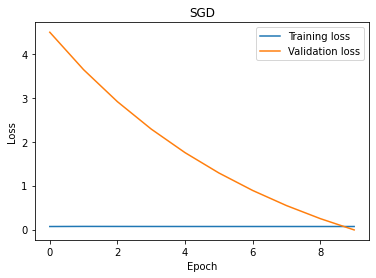

The algorithm seems to have gotten stuck in a local minimum. Perhapse using learning rate decay might help? Reducing lr and lambda and increasing epochs should improve model fitting.


In [107]:
import matplotlib.pyplot as plt

%matplotlib inline


plt.plot(range(num_epoch), sgd_train_losses, sgd_valid_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('SGD')
plt.show()

print('The algorithm seems to have gotten stuck in a local minimum. Perhapse using learning rate decay might help? Reducing lr and lambda and increasing epochs should improve model fitting.')

##### Please run the following cell to evaluate your model with Mini-batch GD

In [63]:
y_hat = mini_gd_lr.predict(x_test)
y_true = np.argmax(y_test, axis=1)

precision = precision_score(y_true, y_hat, average=None)
recall = recall_score(y_true, y_hat, average=None)

print('Mini-batch GD')
print()
print('  Precision:')
print(f'    class {0}: {precision[0]:.4f}, class {1}: {precision[1]:.4f}, class {2}: {precision[2]:.4f}, class {3}: {precision[3]:.4f}')
print()
print('  Recall:')
print(f'    class {0}: {recall[0]:.4f}, class {1}: {recall[1]:.4f}, class {2}: {recall[2]:.4f}, class {3}: {recall[3]:.4f}')

Mini-batch GD

  Precision:
    class 0: 0.0330, class 1: 0.0064, class 2: 0.0232, class 3: 0.0148

  Recall:
    class 0: 0.0437, class 1: 0.0089, class 2: 0.0279, class 3: 0.0011


##### Please run the following cell to plot training loss and validation loss for Mini-batch GD

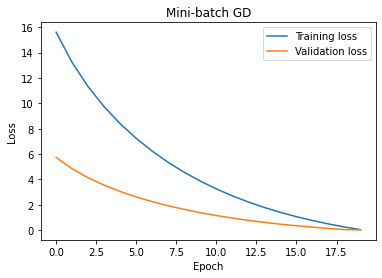

In [64]:
plt.plot(range(num_epoch), mini_gd_train_losses, mini_gd_valid_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('Mini-batch GD')
plt.show()

## 3. Cross-Validation (10 points)

You are required to implement cross-validation, and use it to choose the best $\lambda$.


### 3.1 Reload dataset

In [21]:
text_trainc = train_df['text'].values.astype(str)
label_trainc = train_df['label'].values.astype(int) - 1 # -1 because labels start from 1

text_testc = test_df['text'].values.astype(str)
label_testc = test_df['label'].values.astype(int) - 1 # -1 because labels start from 1

### 3.2 Define the range of $\lambda$. (Fill the code)

In [94]:
lambdas = [1E-2,1E-4,1E-6,1E-8] ## Fill the values of lambda you want to evaluate in the list

### 3.3 Implement cross-validation. (Fill the code)

In [95]:
from sklearn.utils import shuffle
#from tqdm import trange

#vocab_size = 10

extractor = TfIdfExtractor(vocab_size=vocab_size)
extractor.fit(text_trainc)

x_trainc = extractor.transform(text_trainc)
x_testc = extractor.transform(text_testc)


# convert label to one-hot vector
y_trainc = np.zeros((label_trainc.shape[0], num_class))
y_trainc[np.arange(label_trainc.shape[0]), label_trainc] = 1

y_testc = np.zeros((label_testc.shape[0], num_class))
y_testc[np.arange(label_testc.shape[0]), label_testc] = 1

x_trainc, y_trainc = shuffle(x_trainc,y_trainc)

trainc_size = x_trainc.shape[0]
#print('train size =',train_size)
k = 10
lr = 1E-4
batch_size = int(trainc_size/k)
#print('batch size =',batch_size)
eps = 5
losses = []

for lam in tqdm(lambdas, desc='cross val'):
    loss = 0
    model = LogisticRegression(vocab_size, num_class, lam)
    for i in range(k):
        xv = x_trainc[i*batch_size:(i+1)*batch_size]
        yv = y_trainc[i*batch_size:(i+1)*batch_size]
        xt = np.concatenate([x_trainc[:i*batch_size],x_trainc[(i+1)*batch_size:]])
        yt = np.concatenate([y_trainc[:i*batch_size],y_trainc[(i+1)*batch_size:]])
        mini_gd_train_losses, mini_gd_valid_losses = mini_batch_gd(model, xt, yt, xv, yv, batch_size, lr, lam, eps)
        if loss == 0:
                loss = mini_gd_valid_losses[-1]
        else:
                loss = (loss + mini_gd_valid_losses[-1]) / 2
    losses.append(loss)

for i in range(len(lambdas)):
    print('Lambda:', lambdas[i],', average k-fold cross val loss:', losses[i])

### End

fitting text:   0%|          | 0/120000 [00:00<?, ?it/s]

transforming:   0%|          | 0/120000 [00:00<?, ?it/s]

transforming:   0%|          | 0/7600 [00:00<?, ?it/s]

cross val:   0%|          | 0/4 [00:00<?, ?it/s]

Lambda: 0.01 , average k-fold cross val loss: 19.054154536954492
Lambda: 0.0001 , average k-fold cross val loss: 18.360750120268676
Lambda: 1e-06 , average k-fold cross val loss: 19.334570313460645
Lambda: 1e-08 , average k-fold cross val loss: 19.355079816036394


In [96]:
num_epoch = 20
lam = 1E-4
print('best lambda value was 1E-4')
mini_gd_lr = LogisticRegression(vocab_size, num_class, 1E-4)
mini_gd_train_losses, mini_gd_valid_losses = mini_batch_gd(mini_gd_lr, x_trainc, y_trainc, x_testc, y_testc, batch_size, lr, 1E-4, num_epoch)

y_hat = mini_gd_lr.predict(x_test)
y_true = np.argmax(y_testc, axis=1)

precision = precision_score(y_true, y_hat, average=None)
recall = recall_score(y_true, y_hat, average=None)

print('Mini-batch GD')
print()
print('  Precision:')
print(f'    class {0}: {precision[0]:.4f}, class {1}: {precision[1]:.4f}, class {2}: {precision[2]:.4f}, class {3}: {precision[3]:.4f}')
print()
print('  Recall:')
print(f'    class {0}: {recall[0]:.4f}, class {1}: {recall[1]:.4f}, class {2}: {recall[2]:.4f}, class {3}: {recall[3]:.4f}')

best lambda value was 1E-4
Mini-batch GD

  Precision:
    class 0: 0.2671, class 1: 0.2433, class 2: 0.2490, class 3: 0.2680

  Recall:
    class 0: 0.2405, class 1: 0.2289, class 2: 0.2547, class 3: 0.3042


### 3.4 Report the best $lambda$ value, and report the recall and precision for each category on the test set.

From the tested lambda values, the best one w.r.t. the other fixed hyperparameters seems to be 0.0001.
The precision and recall results were found to be as following: (note the model was evaluated using minibatch_gd with batch size = train_size/10)

  Precision:
    class 0: 0.2671, class 1: 0.2433, class 2: 0.2490, class 3: 0.2680

  Recall:
    class 0: 0.2405, class 1: 0.2289, class 2: 0.2547, class 3: 0.3042

# 4. Conclusion

provide an analysis for the results

From the above experement, it seems that sgd is much harder and computationally intensive way to optimize the model over the loss landscape compared to minibatch gd. Is this because we average the losses and in turn are "smoothening" the loss landscape?
Anothe interesting thing that is seen is that for a decently large minibatch size, the regularization factor lambda seems to produce the best result when it is close to the value of learning rate alpha. Intuitively, having a slightly smaller alpha and lambda value with more epochs should result in better optimization of the model's parameters.
Due to time and computational constraints, I limited my vocab size to 1000 and ran the code for a max of 20 epochs. I believe the model would yield better results if the hyper parameters are optimized better using k-fold cross val over larger cross val epochs. I used 5 eps for this implementation but in the real world, I would prefer to run cross val for 10-20 eps depending on model complexity.
Overall, the model seems to be performing better after cross validation of lambda value wrt other fixed hyperparameters. Another way to estimate the best hypermarater combination might be to loop over various combinations of these hyper parameters and pic the best perfoming combination. In any case, the precision and recall scores have improved. But they are no way near perfect for real world use. Increasing the vocab size might help to a certain extent.